# Tutorial 3 - Sensitivity kernels for sea level point measurements. 

In this tutorial we show how sensitivity kernels for point measurements of sea level can be calculated based on the reciprocity theorem of Al-Attar *et al.* (2024). Let $\mathbf{x}_{0}$ be an observation point on the surface, $\partial M$ of the earth model. It can be shown that 
$$
\Delta SL(\mathbf{x}_{0}) = \int_{\partial M} \Delta SL^{\dagger}\, \zeta \, \mathrm{d} S, 
$$
where $\zeta$ is the applied direct load and $\Delta SL^{\dagger}$, which is known as the **adjoint sea level change**, is obtained by solving the sea level equation subject to a direct load $\zeta^{\dagger} = \delta_{\mathbf{x}_{0}}$.


This idea is implemented in the code below, and we verify that the stated integral does indeed recover the sea level change at the observation point. 

In [1]:
# Import necessary modules for this notebook. 
import numpy as np
import matplotlib.pyplot as plt
import pyslfp as sl

# Set up the FingerPrint instance.
fingerprint = sl.FingerPrint()

# Set the initial sea level and ice thickness.
fingerprint.set_state_from_ice_ng()

# Set the observation point to Boston, MA. 
lat = 42.3555
lon = -71.0565

# Generate data from an ice load. 
ice_thickness_change = -1* fingerprint.northern_hemisphere_projection(0) * fingerprint.ice_thickness
direct_load = fingerprint.direct_load_from_ice_thickness_change(ice_thickness_change)
sea_level_change, _, _, _ = fingerprint(direct_load=direct_load, rtol=1e-9)

# Evaluate the sea level change at the observation point
observed_value = fingerprint.point_evaulation(sea_level_change, lat, lon)
print(f'observed sea level change =  {observed_value:.8f}')

# Set up the point load and compute the sensitivity kernel. 
point_load = fingerprint.point_load(lat, lon)
adjoint_sea_level_change,_,_,_ = fingerprint(direct_load=point_load, rtol=1e-9)

# Integrate the adjoint sea level change against the direct load:
predicted_value = fingerprint.integrate(adjoint_sea_level_change * direct_load)
print(f'predicted sea level change =  {predicted_value:.8f}')

# Print the relative error. This should be of the same order of rtol used in the solution 
# of the sea level equation. 
print(f'relative error = {np.abs(observed_value-predicted_value)/np.abs(observed_value)}')

observed sea level change =  2.83785427
predicted sea level change =  2.83787848
relative error = 8.529532024713748e-06


A plot of the adjoint sea level is shown below:

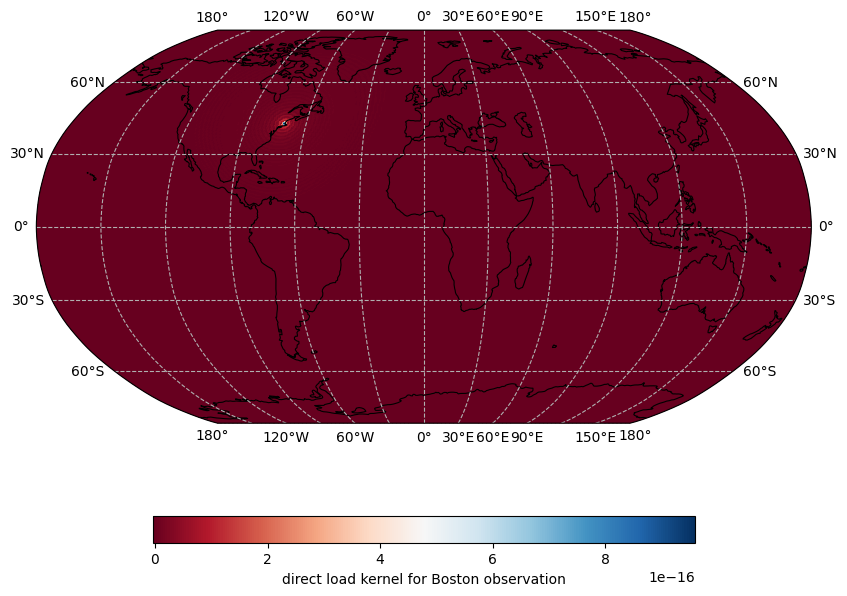

In [2]:
fig, ax, im = sl.plot(adjoint_sea_level_change)
fig.colorbar(im, ax=ax, orientation="horizontal", shrink=0.7, label="direct load kernel for Boston observation")
plt.show()

Here we see that the sensitivity of the sea level measurement to the direct load is sharply peaked at the observation point. In the case that we consider only ice loading, we can write $\zeta = \rho_{i}(1-C) \Delta I$, and hence we have 
$$
\Delta SL(\mathbf{x}_{0}) = \int_{\partial M} \rho_{i}(1-C)\Delta SL^{\dagger}\, \Delta I \, \mathrm{d} S.
$$
We plot this kernel with respect to ice thickness below, projecting its values onto the present-day ice sheet geometry. 

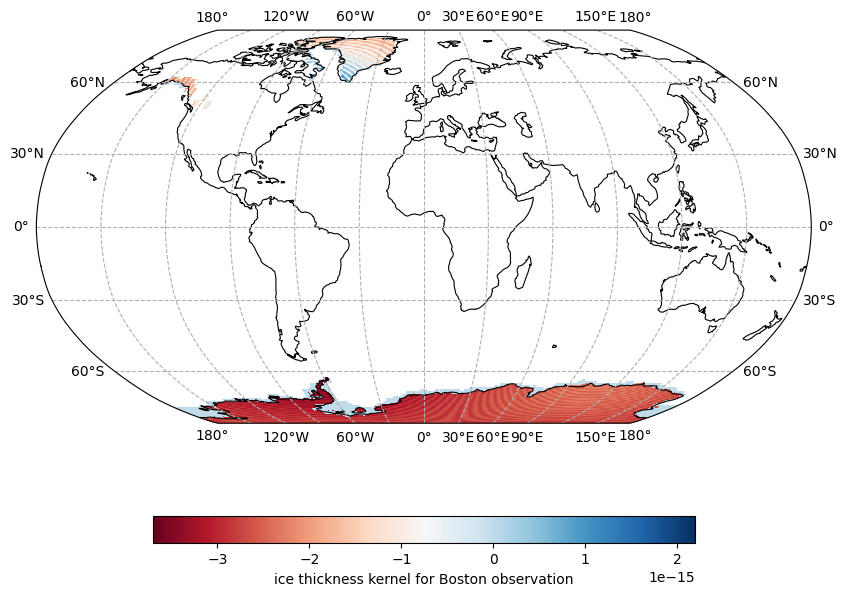

In [3]:
kernel = fingerprint.direct_load_from_ice_thickness_change(adjoint_sea_level_change)
fig, ax, im = sl.plot(kernel * fingerprint.ice_projection())
fig.colorbar(im, ax=ax, orientation="horizontal", shrink=0.7, label="ice thickness kernel for Boston observation")
plt.show()

Within this ice thickness kernel we can see clear oscillations linked to the trunction of the spherical harmonic expansions. Indeed, such oscillations can be seen in the direct load kernel too. These are non-physical features that arise because the kernels are generalised functions. When used within the solution of inverse problems, there exist rigorous methods for dealing with this complication. For the moment, however, we can remove undesirable feature from the plots by smoothing the delta function in the adjoint problem over a suitable length-scale. This is equivalent to saying that our observation is not a point measurement but a certain spatial average. So long as the underlying sea level change is sufficiently smooth such a spatial average will produce a practically identical value to the true point measurement. 

The code below repeats the adjoint calculation using a smoothed delta function and then plots the ice thickness kernel. 

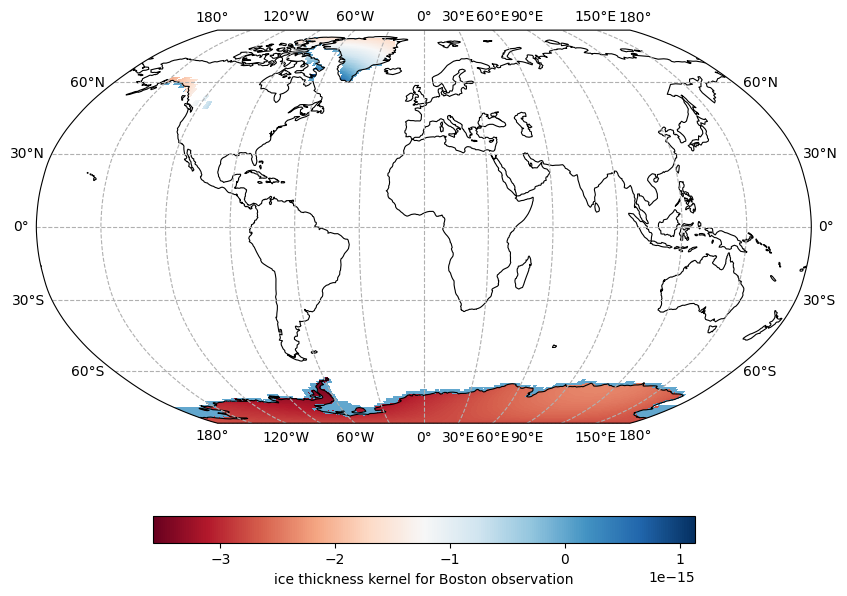

In [4]:
point_load = fingerprint.point_load(lat, lon, smoothing_angle=2)
adjoint_sea_level_change,_,_,_ = fingerprint(direct_load=point_load, rtol=1e-9)
kernel = fingerprint.direct_load_from_ice_thickness_change(adjoint_sea_level_change)
fig, ax, im = sl.plot(kernel * fingerprint.ice_projection())
fig.colorbar(im, ax=ax, orientation="horizontal", shrink=0.7, label="ice thickness kernel for Boston observation")
plt.show()